eda-viz-nlp


In [1]:
%ls data

archive.zip                            olist_order_reviews_dataset.csv
olist_customers_dataset.csv            olist_orders_dataset.csv
olist_geolocation_dataset.csv          olist_products_dataset.csv
olist_order_items_dataset.csv          olist_sellers_dataset.csv
olist_order_payments_dataset.csv       product_category_name_translation.csv


# <font color="darkslateblue" size=+2.5><b>Libraries</b></font>

In [2]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# # Utilities
# from viz_utils import *
# from custom_transformers import *
# from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

# <font color="darkslateblue" size=+2.5><b>Reading the Data</b></font>

In [42]:
# Reading all the files
olist_customer = pd.read_csv('data/olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('data/olist_geolocation_dataset.csv')
olist_orders = pd.read_csv('data/olist_orders_dataset.csv')
olist_order_items = pd.read_csv('data/olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('data/olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv')
olist_products = pd.read_csv('data/olist_products_dataset.csv')
olist_sellers = pd.read_csv('data/olist_sellers_dataset.csv')
olist_category = pd.read_csv('data/product_category_name_translation.csv')

In [5]:
# Collections for each dataset
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers, olist_category]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers', 'olist_category']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['null_amount'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,null_amount,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,99224,7,145903,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,
8,olist_category,71,2,0,0,


In [7]:
# df_overview = pd.DataFrame({})
# name_col = []
# for name, df in zip(names, datasets):
#     name_col += [name] * df.shape[1]
#     df_overview = df_overview.append(data_overview(df))
#     df_overview['dataset_name'] = name_col

# df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
# df_overview

# <font color="darkslateblue" size=+2.5><b>Exploratory Data Analysis</b></font>

각 주제(주문, 고객, 제품, 품목 및 기타)에 대한 그래픽을 탐색

## <font color="dimgrey" size=+2.0><b>Total Orders on E-Commerce</b></font>

___
* _각 상태에 대해 얼마나 많은 주문이 있는가?_
___

#### viz_utils의 single_countplot 함수 추가
[viz_utils | Kaggle](https://www.kaggle.com/thiagopanini/viz-utils/data)

In [10]:
# Formatando eixos do matplotlib
def format_spines(ax, right_border=True):
    """
    This function sets up borders from an axis and personalize colors

    Input:
        Axis and a flag for deciding or not to plot the right border
    Returns:
        Plot configuration
    """
    # Setting up colors
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#CCCCCC')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')

In [11]:
def single_countplot(df, ax, x=None, y=None, top=None, order=True, hue=False, palette='plasma',
                     width=0.75, sub_width=0.3, sub_size=12):
    """
    Parâmetros
    ----------
    classifiers: conjunto de classificadores em forma de dicionário [dict]
    X: array com os dados a serem utilizados no treinamento [np.array]
    y: array com o vetor target do modelo [np.array]

    Retorno
    -------
    None
    """

    # Verificando plotagem por quebra de alguma variável categórica
    ncount = len(df)
    if x:
        col = x
    else:
        col = y

    # Verificando a plotagem de top categorias
    if top is not None:
        cat_count = df[col].value_counts()
        top_categories = cat_count[:top].index
        df = df[df[col].isin(top_categories)]

    # Validando demais argumentos e plotando gráfico
    if hue != False:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index, hue=hue)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, hue=hue)
    else:
        if order:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax, order=df[col].value_counts().index)
        else:
            sns.countplot(x=x, y=y, data=df, palette=palette, ax=ax)

    # Formatando eixos
    format_spines(ax, right_border=False)

    # Inserindo rótulo de percentual
    if x:
        for p in ax.patches:
            x = p.get_bbox().get_points()[:, 0]
            y = p.get_bbox().get_points()[1, 1]
            ax.annotate('{}\n{:.1f}%'.format(int(y), 100. * y / ncount), (x.mean(), y), ha='center', va='bottom')
    else:
        for p in ax.patches:
            x = p.get_bbox().get_points()[1, 0]
            y = p.get_bbox().get_points()[:, 1]
            ax.annotate('{} ({:.1f}%)'.format(int(x), 100. * x / ncount), (x, y.mean()), va='center')


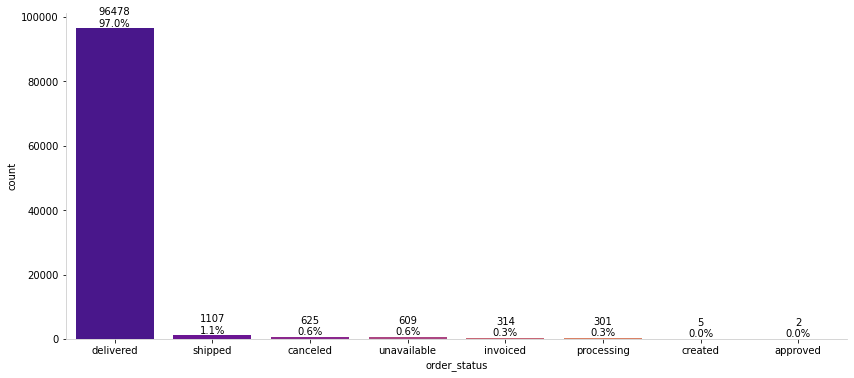

In [12]:
#by using custom countplots in (viz_utils)
df_orders = olist_orders.merge(olist_customer, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='order_status', ax=ax)
plt.show()

- 배달된 주문에서 가장 많은 주문이 발생
- 전체 주문의 3%만이 다른 상태

___
* _Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?_
___

구매 주문 측면에서 e-commerce의 진화 -> 이를 위해 다음 주제에 따라 `order_purchase_timestamp`에 대한 일부 정보를 추출

    1. 타임스탬프 컬럼 변환
    2. datetime 컬럼(year, month, day, day of week and hour)에서 시간 속성을 추출
    3. 이 속성을 사용하여 e-commerce 시나리오를 평가

In [43]:
# Changing the data type for date columns
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m%d'))

# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))

# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night


데이터 세트 기간 동안 brazilian e-commerce의 주문량에 대한 완전한 분석을 목적 -> 다음 질문에 답하는 것을 목표로 `GridSpec`을 사용한 세 개의 그래프

1. brazilian e-commerce의 성장 추세가 있는가?
2. 브라질 고객들이 온라인 구매를 주로 하는 요일은?
3. 브라질 고객들이 구매하는 시간(Dawn, Morning, Afternoon or Night)은?

<ipython-input-44-6d7bc6a61a25>:34: UserWarning:

This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 



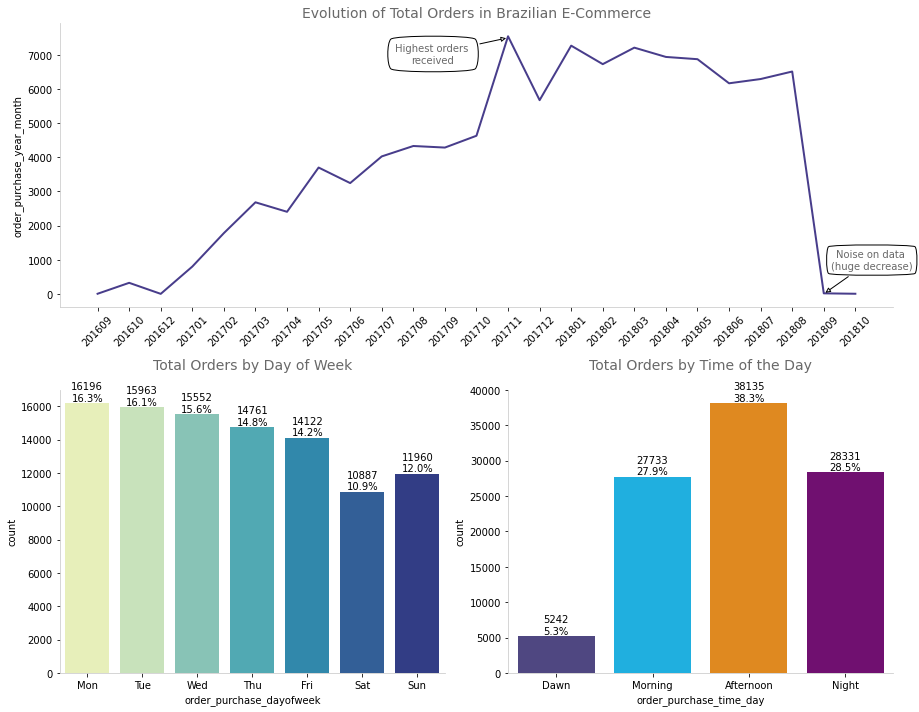

In [44]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolution of Total Orders in Brazilian E-Commerce', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orders by Day of Week', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orders by Time of the Day', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

- E-commerce on Brazil은 실제로 시간이 지남에 따라 성장하는 추세. 특정 월에 피크가 있는 일부 계절성을 볼 수 있지만 일반적으로 고객이 이전보다 온라인으로 물건을 구매하는 경향이 더 많음.
- 월요일은 브라질 고객이 선호하는 날이며 오후에 더 많이 구매하는 경향

* Obs: 2018년 8월과 2018년 9월 사이에 급격한 감소가 있었고 그 원인은 데이터의 노이즈와 관련이 있을 수 있음. 2017년과 2018년 사이의 추가 비교를 위해 두 연도 모두에서 1월과 8월 사이의 주문을 고려.

___
* _E-commerce: a comparison between 2017 and 2018_
___

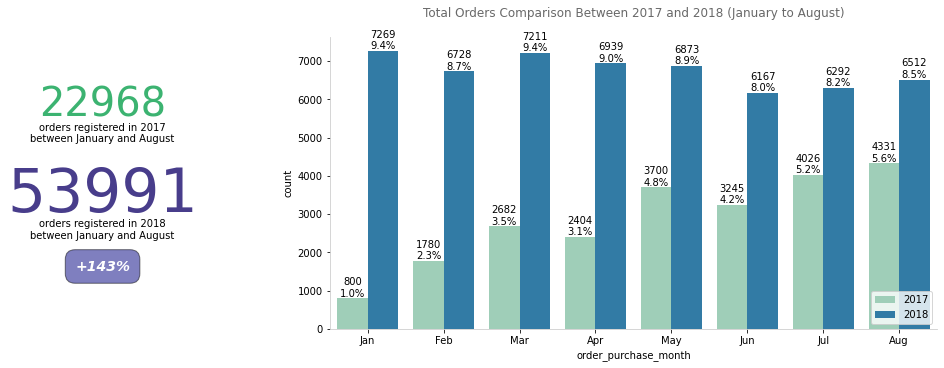

In [45]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
year_orders = df_orders_compare['order_purchase_year'].value_counts()
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'orders registered in 2017\nbetween January and August', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orders registered in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
single_countplot(df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total Orders Comparison Between 2017 and 2018 (January to August)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

## <font color="dimgrey" size=+2.0><b>E-Commerce Around Brazil</b></font>

brazilian's states e-commerce에 대한 해결 방법 분석을 위해 데이터를 준비하기 위해 다음 단계 진행

1. order data를 order_items 데이터에 병합
2. API(브라질 정부)를 사용하여 각 customer_state의 지역을 반환
3. 비즈니스 질문을 보증하는 유용한 차트를 사용

* Brazilian APIs ans links for geolocation info:

        https://servicodados.ibge.gov.br/api/docs/localidades?versao=1

In [46]:
# Merging orders and order_items
df_orders_items = df_orders.merge(olist_order_items, how='left', on='order_id')

# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = olist_geolocation[olist_geolocation.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()

# Merging all the informations
df_orders_items = df_orders_items.merge(br_info, how='left', left_on='customer_state', right_on='sigla')
df_orders_items = df_orders_items.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
df_orders_items.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,id,sigla,nome,nome_regiao,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,Oct,201710,20171002,2,0,Mon,10,Morning,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,35,SP,São Paulo,Sudeste,3149.0,-23.583885,-46.587473,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,Jul,201807,20180724,24,1,Tue,20,Night,1.0,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,29,BA,Bahia,Nordeste,47813.0,-12.945892,-45.016313,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,Aug,201808,20180808,8,2,Wed,8,Morning,1.0,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,52,GO,Goiás,Centro-Oeste,75265.0,-16.752735,-48.522139,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,Nov,201711,20171118,18,5,Sat,19,Night,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,24,RN,Rio Grande do Norte,Nordeste,59296.0,-5.778488,-35.281450,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,Feb,201802,20180213,13,1,Tue,21,Night,1.0,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,35,SP,São Paulo,Sudeste,9195.0,-23.760018,-46.524784,santo andre,SP


___
* _지역, 주, 도시별 고객 주문 개요_
___

In [61]:
# Filtering data between 201701 and 201808
df_orders_filt = df_orders_items[(df_orders_items['order_purchase_year_month'].astype(int) >= 201701)]
df_orders_filt = df_orders_filt[(df_orders_filt['order_purchase_year_month'].astype(int) <= 201808)]

# Grouping data by region
df_regions_group = df_orders_filt.groupby(by=['order_purchase_year_month', 'nome_regiao'], as_index=False)
df_regions_group = df_regions_group.agg({'customer_id': 'count', 'price': 'sum'}).sort_values(by='order_purchase_year_month')
df_regions_group.columns = ['month', 'region', 'order_count', 'order_amount']
df_regions_group.reset_index(drop=True, inplace=True)

# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

#### viz_utils의 AnnotateBars 클래스 추가
[viz_utils | Kaggle](https://www.kaggle.com/thiagopanini/viz-utils/data)

In [70]:
import matplotlib
from warnings import filterwarnings
filterwarnings('ignore')
from typing import *
from dataclasses import dataclass
from math import ceil

Patch = matplotlib.patches.Patch
PosVal = Tuple[float, Tuple[float, float]]
Axis = matplotlib.axes.Axes
PosValFunc = Callable[[Patch], PosVal]

class AnnotateBars:
    font_size: int = 10
    color: str = "black"
    n_dec: int = 2
    def horizontal(self, ax: Axis, centered=False):
        def get_vals(p: Patch) -> PosVal:
            value = p.get_width()
            div = 2 if centered else 1
            pos = (
                p.get_x() + p.get_width() / div,
                p.get_y() + p.get_height() / 2,
            )
            return value, pos
        ha = "center" if centered else  "left"
        self._annotate(ax, get_vals, ha=ha, va="center")
    def vertical(self, ax: Axis, centered:bool=False):
        def get_vals(p: Patch) -> PosVal:
            value = p.get_height()
            div = 2 if centered else 1
            pos = (p.get_x() + p.get_width() / 2,
                   p.get_y() + p.get_height() / div
            )
            return value, pos
        va = "center" if centered else "bottom"
        self._annotate(ax, get_vals, ha="center", va=va)
    def _annotate(self, ax, func: PosValFunc, **kwargs):
        cfg = {"color": self.color,
               "fontsize": self.font_size, **kwargs}
        for p in ax.patches:
            value, pos = func(p)
            ax.annotate(f"{value:.{self.n_dec}f}", pos, **cfg)


TypeError: AnnotateBars() takes no arguments

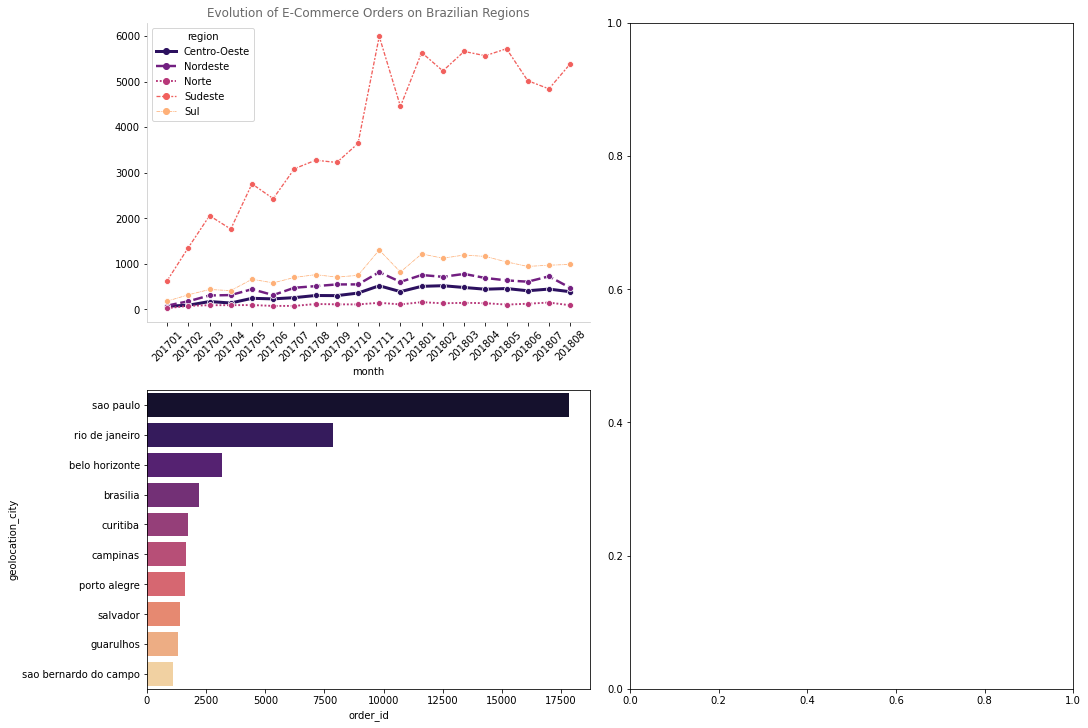

In [72]:
# Creating and preparing figure and axis
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

# Count of orders by region
sns.lineplot(x='month', y='order_count', ax=ax1, data=df_regions_group, hue='region', 
             size='region', style='region', palette='magma', markers=['o'] * 5)
format_spines(ax1, right_border=False)
ax1.set_title('Evolution of E-Commerce Orders on Brazilian Regions', size=12, color='dimgrey')
ax1.set_ylabel('')
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)

# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, ax=ax2, palette='magma')
AnnotateBars(n_dec=0, font_size=10, color='black').horizontal(ax2)
format_spines(ax2, right_border=False)
ax2.set_title('Top 10 Brazilian Cities with More Orders', size=12, color='dimgrey')
ax2.set_ylabel('')

# Total orders by state
single_countplot(y='customer_state', ax=ax3, df=df_orders_filt, palette='viridis')
ax3.set_title('Total of Customers Orders by State', size=12, color='dimgrey')
ax3.set_ylabel('')

plt.show()

___
* _브라질의 고객 분포(지도에서 2018년의 30,000개 주문 샘플)_
___

In [73]:
# Zipping locations
lats = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(df_orders_items.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

#### products 파일의 카테고리 이름 영어로 변경

In [36]:
# olist_products1 = pd.read_csv('data/olist_products_dataset.csv')
# olist_category1 = pd.read_csv('data/product_category_name_translation.csv')


# category = pd.merge(olist_products1,olist_category1, on="product_category_name", how = 'left')


In [37]:
# category=category[['product_id', 'product_category_name_english', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']]

In [38]:
# category=category.rename(columns={'product_category_name':'product_category_name_port','product_category_name_english':'product_category_name'})

In [39]:
# category

,product_id,product_category_name,product_category_name_port,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,furniture_decor,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construction_tools_lights,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,bed_bath_table,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,computers_accessories,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [40]:
# category.to_csv('./olist_products_dataset.csv', index=False)